## Data
***
### Import Libraries

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import holidays
from workalendar.europe import UnitedKingdom
import warnings

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (18,7)

***
### Functions

In [155]:
def get_yf_data(ticker:str, start:str, end:str, column:str = None):
    """
    Retrieve historical financial data for a given stock ticker symbol within a specified date range.

    Parameters:
        ticker (str, required): The ticker symbol fo the stock you want to return
        start  (str, required): The start date of the historical data range in 'YYYY-MM-DD' format.
        end    (str, required): The end date of the historical data range in 'YYYY-MM-DD' format.
        column (str, optional): The specific data column to retrieve (e.g., 'Open', 'Close').
                                If None (default), returns a DataFrame with all available columns.
    Returns:
        pandas.DataFrame: returns a pandas DataFrame containing data for that specific column or all columns.
    """
    
    if column == None:
        return yf.Ticker(ticker).history(start=start, end=end)
    else:
        return yf.Ticker(ticker).history(start=start, end=end)[column]
    
def log_cols(df, columns):
    for col in columns:
        df[col] = np.log(df[col])
        
def normalise_cols(df, columns):
    for col in columns:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
        

***
### Stocks

In [139]:
stocks = {'HWG.L' : None, # HWG.L  - Harworth Group PLC
          'BLND.L': None, # BLND.L - British Land Company PLC
          'SGRO.L': None, # SGRO.L - Segro PLC
          'BOOT.L': None, # BOOT.L - Henry Boot PLC
          'ASLI.L': None, # ASLI.L - Aberdeen Standard European Logistics Income PLC
          'DLN.L' : None} # DLN.L  - Derwent London PLC

palette = {'HWG.L' :'#002d61',
          'BLND.L': '#017FAC', 
          'SGRO.L': '#CC171F', 
          'BOOT.L': '#0026d1', 
          'ASLI.L': '#50C878',       
          'DLN.L' : '#6a6a6a'} 

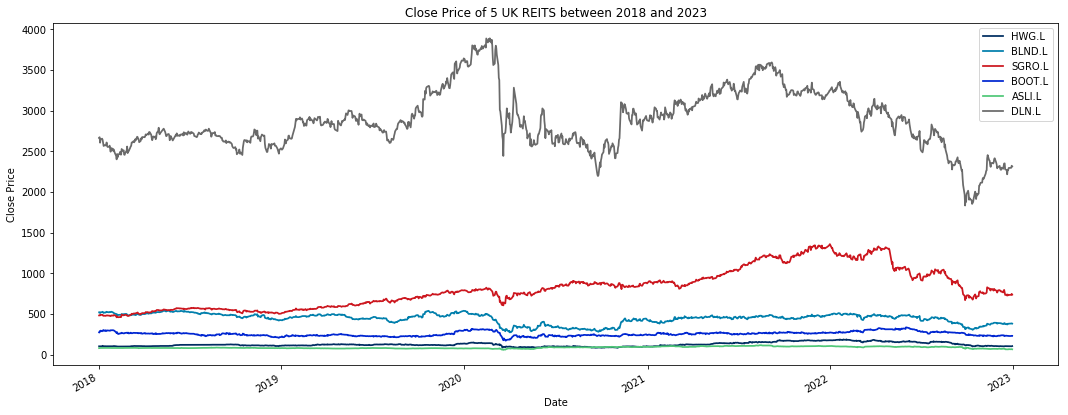

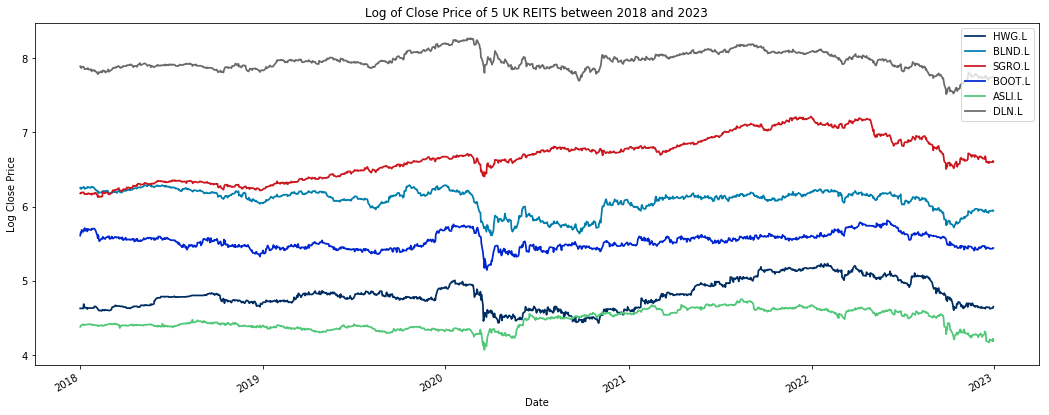

In [140]:
for i in stocks.keys():
    stocks[i] = get_yf_data(i, '2018-01-01', '2022-12-31', 'Close')
    #stocks[i] = np.log(stocks[i])
    stocks[i].plot(color=palette[i], linewidth=1.75)
    
plt.legend(stocks)
plt.title('Close Price of 5 UK REITS between 2018 and 2023')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

log_stocks = stocks.copy()
for i in log_stocks.keys():
    log_stocks[i] = np.log(stocks[i])
    log_stocks[i].plot(color=palette[i], linewidth=1.75)

plt.legend(log_stocks)
plt.title('Log of Close Price of 5 UK REITS between 2018 and 2023')
plt.xlabel('Date')
plt.ylabel('Log Close Price')
plt.show()

***
### Cleaning Stock Data

In [141]:
def check_missing_values():
    
    uk = UnitedKingdom()
    check_df = pd.DataFrame(columns=['Nulls', 'Missing Dates', 'Missing Workdays'], index=list(stocks.keys()))
    
    for i in stocks.keys():
        stock = pd.DataFrame(stocks[i])

        check_df.loc[i]['Nulls'] = stock['Close'].isnull().sum()
        missing_dates = pd.date_range(start='2018-01-01', end='2022-12-31').difference(stock.index)
        check_df.loc[i]['Missing Dates'] = len(missing_dates)
        missing = 0
        for d in missing_dates:
            if d.weekday() < 5:
                if uk.is_working_day(d):
                    print('Missing Date in %s: %s' % (i, d))
                    missing += 1
        check_df.loc[i]['Missing Workdays'] = missing

    return check_df

In [142]:
check_missing_values()

Missing Date in SGRO.L: 2021-07-29 00:00:00


,Nulls,Missing Dates,Missing Workdays
HWG.L,0,563,0
BLND.L,0,563,0
SGRO.L,0,564,1
BOOT.L,0,563,0
ASLI.L,0,563,0
DLN.L,0,563,0


In [143]:
sgro = pd.DataFrame(stocks['SGRO.L'])

prev_day = pd.DataFrame(data={'Close' : sgro.loc['2021-07-28 00:00:00']['Close'], 'Date' : '2021-07-29 00:00:00'}, index=[0])
prev_day['Date'] = pd.to_datetime(prev_day['Date']) 
prev_day.index = prev_day['Date']
del prev_day['Date']

stocks['SGRO.L'] = stocks['SGRO.L'].append(prev_day['Close'])

In [144]:
check_missing_values()

,Nulls,Missing Dates,Missing Workdays
HWG.L,0,563,0
BLND.L,0,563,0
SGRO.L,0,563,0
BOOT.L,0,563,0
ASLI.L,0,563,0
DLN.L,0,563,0


***
### Inflation
[CPIH Annual Rate](https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l55o/mm23)

In [145]:
# load CPIH Annual Rate (Inflation Rate) Data
inflation = pd.read_csv('series-160823 - CPIH.csv')[181:].reset_index(drop=True)

# change month format to full datetimes
inflation['Title'] = inflation['Title'].apply(lambda x: datetime.strftime(datetime.strptime(x, '%Y %b'), '%Y-%m-%d'))
# change column names
inflation = inflation.rename(columns={'Title': 'inf_month', 'CPIH ANNUAL RATE 00: ALL ITEMS 2015=100': 'CPIH Annual Rate'})

# adjust data types
inflation['inf_month'] = pd.to_datetime(inflation['inf_month'])
inflation['CPIH Annual Rate'] = pd.to_numeric(inflation['CPIH Annual Rate'])

# filter for 2018-2023
inflation = inflation[(inflation['inf_month']>='2018-01-01') & (inflation['inf_month']<='2022-12-31')]

***
### House Price Index
[UK Gov House Price Index](https://www.gov.uk/government/statistical-data-sets/uk-house-price-index-data-downloads-march-2023#download-the-data)

In [146]:
# load HPI data
hpi = pd.read_csv('UK-HPI-full-file-2023-03.csv')

# filter for UK records and only date and average price and index columns
hpi = hpi[hpi['RegionName']=='United Kingdom'] 
hpi = hpi[['Date', 'AveragePrice', 'Index']]

# adjust data types
hpi['Date'] = pd.to_datetime(hpi['Date'])
hpi['Date'] = hpi['Date'].apply(lambda x: datetime.strftime(x, '%Y-%d-%m'))
hpi['Date'] = pd.to_datetime(hpi['Date'])
hpi['AveragePrice'] = pd.to_numeric(hpi['AveragePrice'])
hpi['Index'] = pd.to_numeric(hpi['Index'])

# rename date column
hpi = hpi.rename(columns={'Date':'hpi_date'})

# filter for 2018-2023
hpi = hpi[(hpi['hpi_date'] >= '2018-01-01') & (hpi['hpi_date'] <= '2022-12-31')]

***
### BoE Rates
[Bank of England Bank Rate](https://www.bankofengland.co.uk/boeapps/database/Bank-Rate.asp)

In [147]:
# load BoE data
boe = pd.read_csv('Bank Rate history and data  Bank of England Database.csv')

# adjust data types
boe['Date Changed'] = pd.to_datetime(boe['Date Changed'])

# fill missing dates
full_date_range = pd.date_range(start=boe['Date Changed'].min(), end=boe['Date Changed'].max())
missing_dates = full_date_range.difference(boe['Date Changed'])
boe = boe.set_index('Date Changed')
boe = boe.reindex(full_date_range, method='ffill')

# replace date column
boe['boe_date'] = boe.index
boe = boe.reset_index(drop=True)
 
# filter for 2018-2023
boe = boe[(boe['boe_date'] >= '2018-01-01') & (boe['boe_date'] <= '2022-12-31')]

***
### GDP
[Monthly UK DGP](https://www.ons.gov.uk/economy/grossdomesticproductgdp/bulletins/gdpmonthlyestimateuk/may2023)

In [148]:
# load Monthly UK GDP Data
gdp = pd.read_csv('UK_GDP.csv', skiprows=6)

# re-format date and rename columns
gdp['Date'] = gdp['Date'].apply(lambda x: datetime.strptime(x,'%b-%y').strftime('%m/%d/%Y'))
gdp['Date'] = pd.to_datetime(gdp['Date'])
gdp = gdp.rename(columns={'Date':'gdp_date', 'Monthly GDP':'GDP'})

# filter for 2018-2023
gdp = gdp[(gdp['gdp_date'] >= '2018-01-01') & (gdp['gdp_date'] <= '2022-12-31')]

***
### FTSE 100

In [149]:
ftse = get_yf_data('^FTSE', '2018-01-01', '2022-12-31', 'Close')#.plot()
ftse = pd.DataFrame(ftse)
ftse['Date'] = ftse.index
ftse = ftse.reset_index(level=0, drop=True)

***
### Unemployment
[UK Unemployment Data](https://www.ons.gov.uk/employmentandlabourmarket/peoplenotinwork/unemployment/timeseries/mgsx/lms)

In [150]:
# load unemployment data
unemployment = pd.read_csv('series-280823 - unemployment.csv')[832:].reset_index(drop=True)

# rename columns
unemployment = unemployment.rename(columns={'Title':'unemp_month',
                                            'Unemployment rate (aged 16 and over, seasonally adjusted): %':'Unemployment'})

# adjust data types
unemployment['Unemployment'] = pd.to_numeric(unemployment['Unemployment'])
unemployment['unemp_month'] = pd.to_datetime(unemployment['unemp_month'])

# filter for 2018-2023
unemployment = unemployment[(unemployment['unemp_month'] >= '2018-01-01') & (unemployment['unemp_month'] <= '2022-12-31')]

In [151]:
def add_time_series(main_df, main_date, add_df, add_date, add_date_freq):
    if add_date_freq == 'Month':
        merge_df = pd.merge(main_df.assign(grouper=main_df[main_date].dt.to_period('M')),
                            add_df.assign(grouper=add_df[add_date].dt.to_period('M')),
                            how='left', on='grouper')
    elif add_date_freq == 'Quarter':
        merge_df = pd.merge(main_df.assign(grouper=main_df[main_date].dt.to_period('Q')),
                            add_df.assign(grouper=add_df[add_date].dt.to_period('Q')),
                            how='left', on='grouper')
    elif add_date_freq == "Daily":
        add_df = add_df.rename(columns={add_date:'Date'})
        merge_df = pd.merge(main_df, add_df, how='left', on=main_date)        
        
    return merge_df
    

In [152]:
for i in stocks.keys():
    stock = pd.DataFrame(stocks[i])
    stock['Date'] = stock.index
    stock = add_time_series(stock, 'Date', unemployment, 'unemp_month', 'Month')
    stock = add_time_series(stock, 'Date', inflation,    'inf_month',   'Month')
    stock = add_time_series(stock, 'Date', gdp,          'gdp_date',    'Month')
    stock = add_time_series(stock, 'Date', boe,          'boe_date',    'Daily')
    stock = add_time_series(stock, 'Date', ftse,         'ftse_date',   'Daily')
    stock = add_time_series(stock, 'Date', hpi,          'hpi_date',    'Month')
    stock = stock[['Date', 'Unemployment', 'CPIH Annual Rate', 'GDP', 'Rate', 'AveragePrice', 'Index', 'Close_y', 'Close_x']]
    stock = stock.rename(columns={'CPIH Annual Rate':'Inflation', 'Rate':'BoE Rate', 'Close_y':'FTSE', 'Close_x':'Close'})
    stock.index = stock['Date']
    del stock['Date']
    stocks[i] = stock

In [170]:
s = stocks['HWG.L']
s[s['FTSE'].isnull()]
stocks['HWG.L'].loc['2020-12-22']['FTSE'] = stocks['HWG.L'].loc['2020-12-21']['FTSE']
#s[s['FTSE'].isnull()]

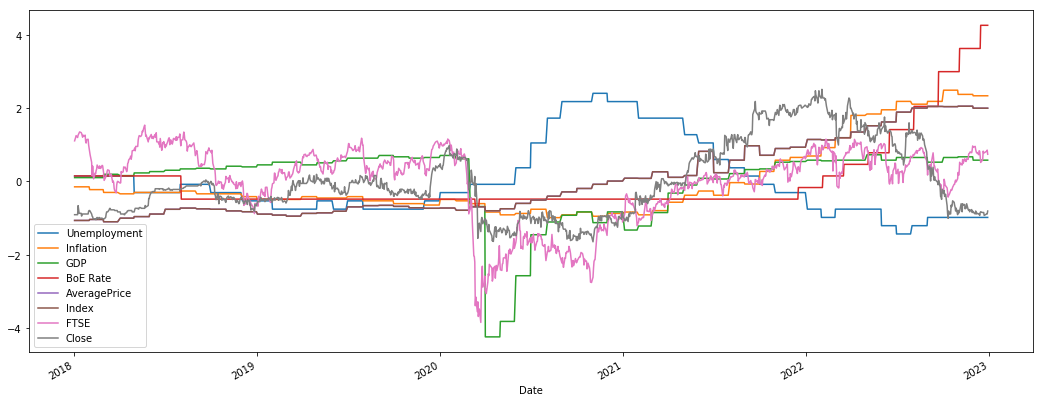

In [157]:
stocks['HWG.L'].plot()

#normalise_cols(stocks['HWG.L'], stocks['HWG.L'].columns)


In [158]:
import seaborn as sns

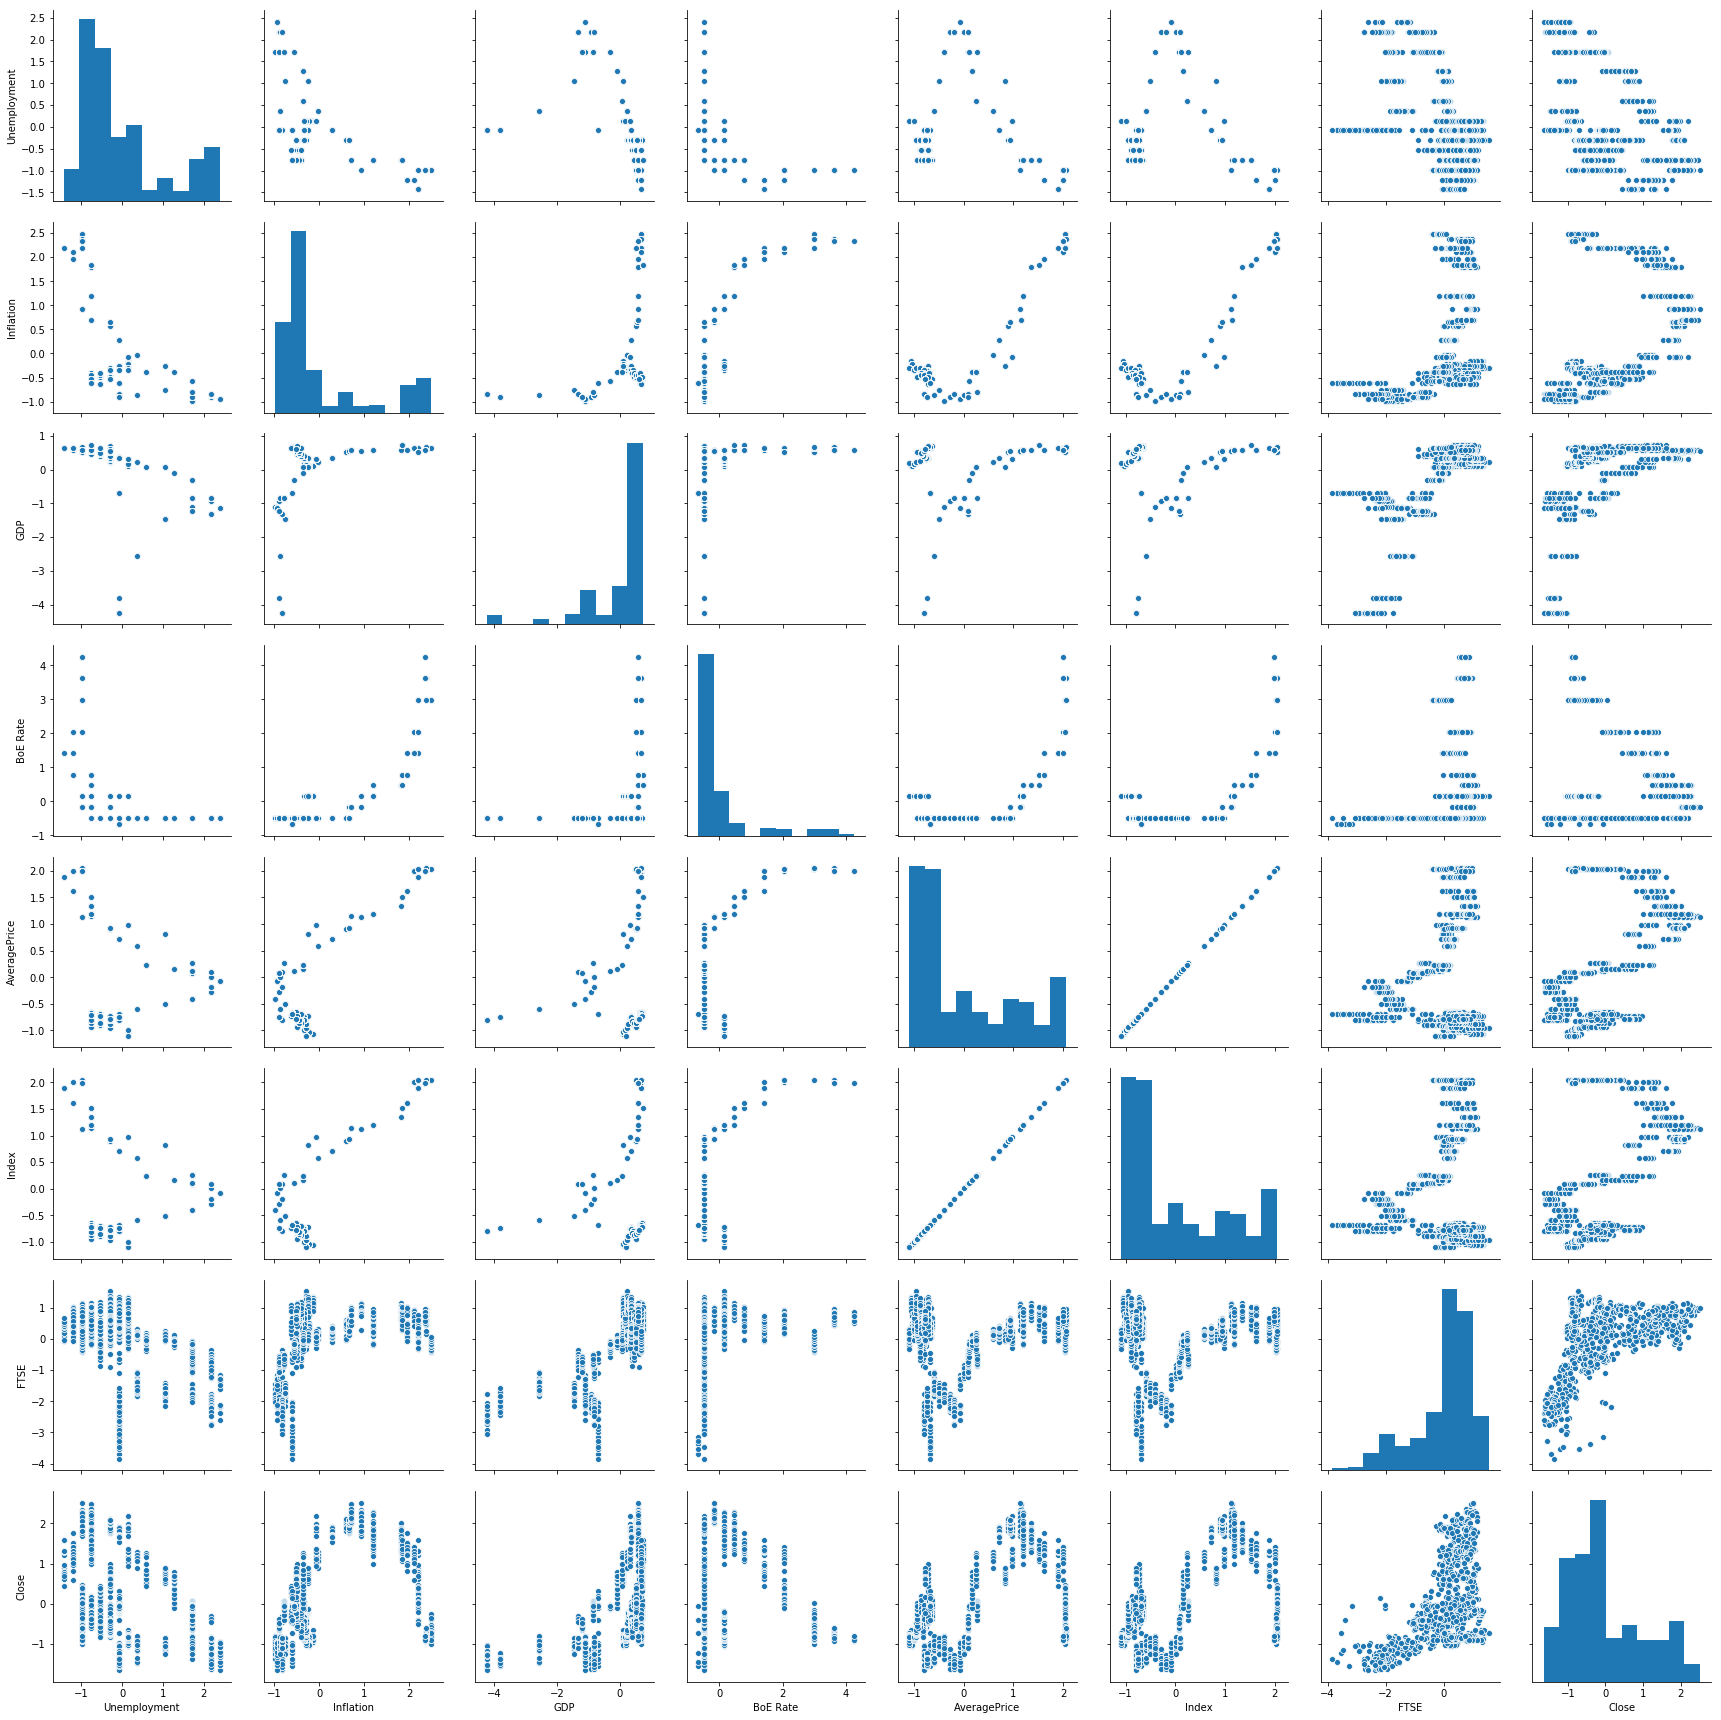

In [159]:
sns.pairplot(
    stocks['HWG.L'],
    height = 3,
    palette = "Set1")

[]

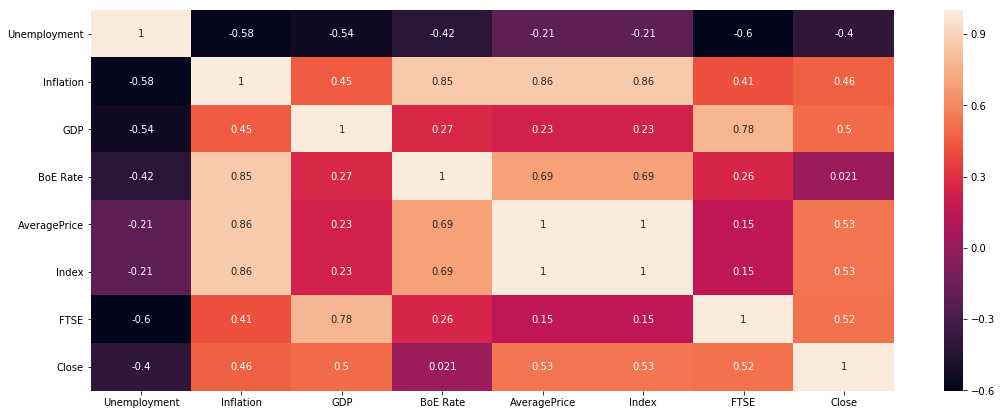

In [166]:
sns.heatmap(stocks['HWG.L'].corr(), annot= True)
plt.plot()

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [175]:
stocks['HWG.L'].to_csv('test.csv')
y = stocks['HWG.L']['Close']
X = stocks['HWG.L'].drop("Close", axis = 1)

X_train,X_test,y_train,y_test = train_test_split(
    X,y, 
    train_size = 0.80, 
    random_state = 4)

0.919
0.894


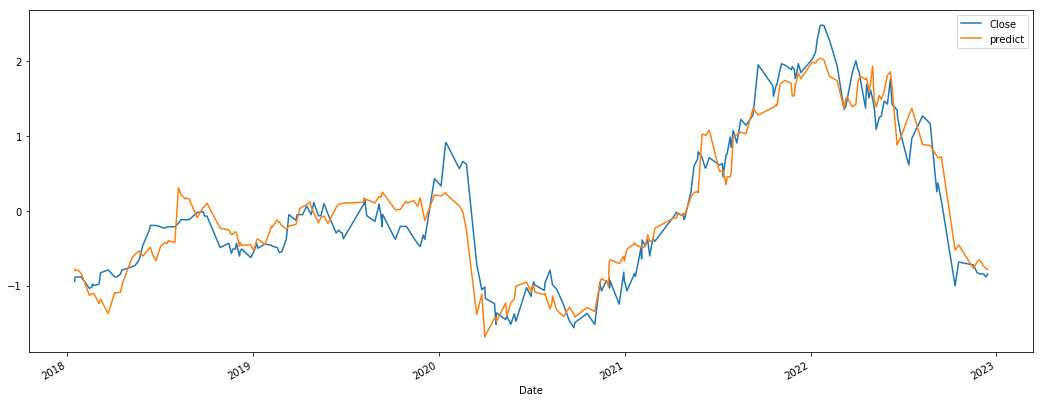

In [176]:
lr = LinearRegression()
lr.fit(X_train,y_train)
print(lr.score(X_test, y_test).round(3))
print(lr.score(X_train, y_train).round(3))
abc = lr.predict(X_test)



a = pd.DataFrame(y_test)
a['predict'] = abc
a.plot()